# Enrichment vignette

First, import required packages.

In [1]:
import pandas as pd
import gopher
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Read the input file. This data comes from a FAK knockout dataset (Table S1) from  Koide E, et al. 2023.

In [2]:
df = pd.read_csv("static/prot_quant.txt", sep='\t')
df.head()

,ID,Protein,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,Q05397,PTK2,-2.859883,2.340355,-99.425405,1.060000e-11,8.690000e-08,12.498542
1,Q15418-2,RPS6KA1,-0.932924,3.128221,-19.062544,5.290000e-07,1.081399e-03,6.609119
2,O14965,AURKA,-0.650304,3.160873,-19.699383,4.270000e-07,1.081399e-03,6.437053
3,P51948-1,MNAT1,-0.500882,3.227122,-14.454300,3.140000e-06,5.143099e-03,4.712882
4,Q9BYT3-1,STK33,-2.075020,2.675332,-27.269400,5.150000e-08,2.106740e-04,4.557334


For gopher we need to reformat the data so the index is the UniProtKB accessions and the columns are the quantitative values we want to test. Since this data has statstic information, we choose the value we want to test. I am choosing `ad.P.Val` here.

In [3]:
input_df = df[["ID", "adj.P.Val"]].set_index("ID")
input_df.head()

,adj.P.Val
ID,
Q05397,8.690000e-08
Q15418-2,1.081399e-03
O14965,1.081399e-03
P51948-1,5.143099e-03
Q9BYT3-1,2.106740e-04


Next I choose the terms I want to search. I am choosing some terms I expect to be enriched in this dataset and some that I do not expect to be enriched. This is optional, you can search all terms.

In [4]:
terms = [
    # should NOT be enriched
    "membrane organization",
    "protein folding",
    "transcription regulator activity",
    # SHOULD be enriched
    "cell adhesion",
    "anatomical structure development",
    "cell motility",
    "cell differentiation",
    "protein phosphorylation",
    "protein autophosphorylation"
]

Run the enrichment on the data with the terms of interest. I also set the descending flag to `False` since we want the lower (more significant) p-values to be ranked lower.

In [5]:
results = gopher.test_enrichment(input_df, go_subset=terms, desc=False)
results.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,GO ID,GO Name,GO Aspect,adj.P.Val
0,GO:0006457,protein folding,P,0.987289
1,GO:0006468,protein phosphorylation,P,0.072794
2,GO:0007155,cell adhesion,P,0.848735
3,GO:0030154,cell differentiation,P,0.267482
4,GO:0046777,protein autophosphorylation,P,0.069585


To visualize the data, we reformat the data and plot the -log10(p-value).

In [6]:
long_df = results.melt(
    ["GO ID", "GO Name", "GO Aspect"],
    var_name="Run",
    value_name="pvalue",
)
long_df["neglogpval"] = -np.log10(long_df["pvalue"])

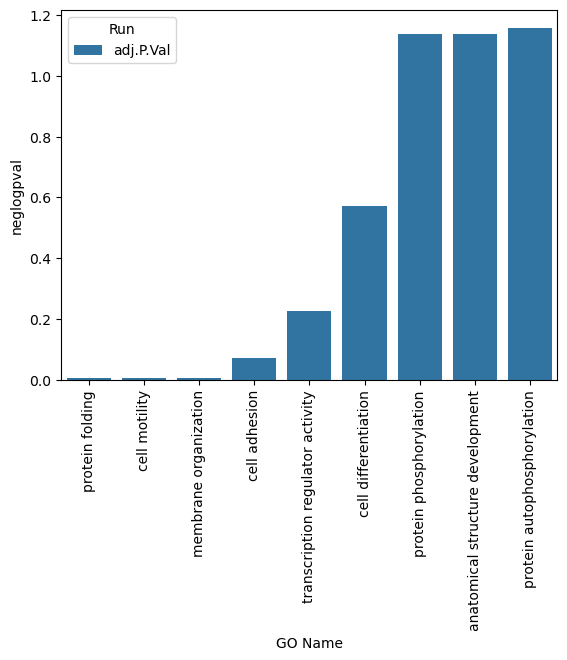

In [9]:
sns.barplot(
    long_df.sort_values(by="neglogpval"),
    x="GO Name",
    y="neglogpval",
    hue="Run",
)
plt.xticks(rotation=90)
plt.show()

If I want to further investigate a term, I can by looking at the protein rankings of that term.

In [12]:
ranks = gopher.get_rankings(input_df, "cell motility")
ranks.head()

,adj.P.Val,in_term
ID,,
Q05397,1.0,True
Q15418-2,3.5,False
P51948-1,5.0,False
Q9BYT3-1,2.0,False
P51946,6.0,False


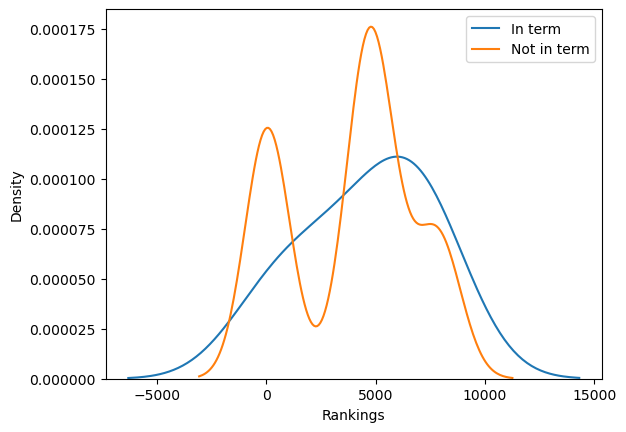

In [26]:
in_term = ranks[ranks["in_term"]]
sns.kdeplot(in_term["adj.P.Val"], label="In term")
out_term = ranks[~ranks["in_term"]]
sns.kdeplot(out_term["adj.P.Val"], label="Not in term")
plt.xlabel("Rankings")
plt.legend()
plt.show()